1.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68606236/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE
)

Found 1000 files belonging to 2 classes.


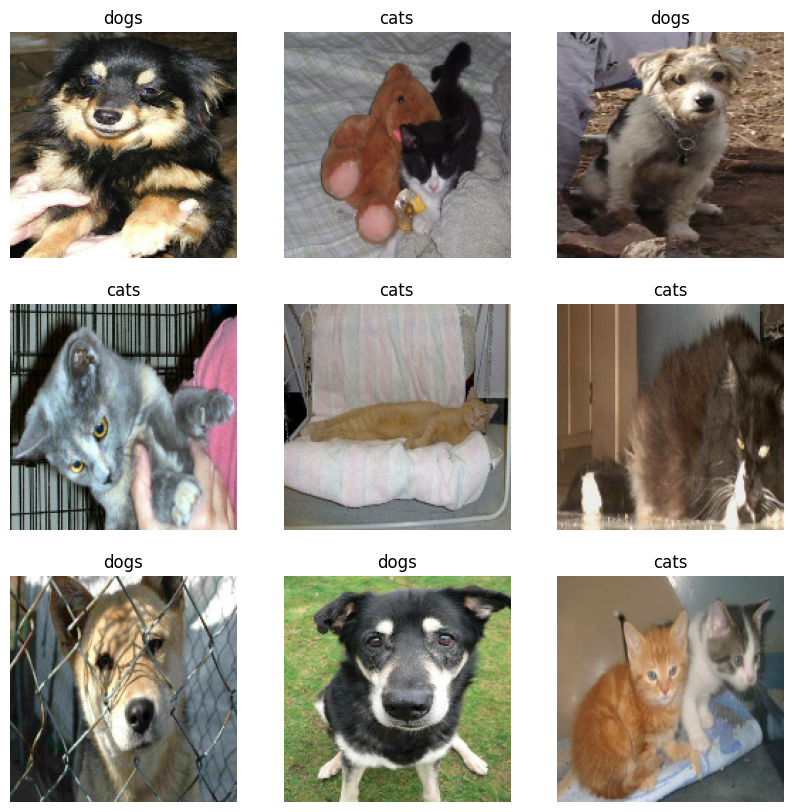

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print(
    "Number of validation batches: %d"
    % tf.data.experimental.cardinality(validation_dataset)
)
print("Number of test batches: %d" % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
    ]
)

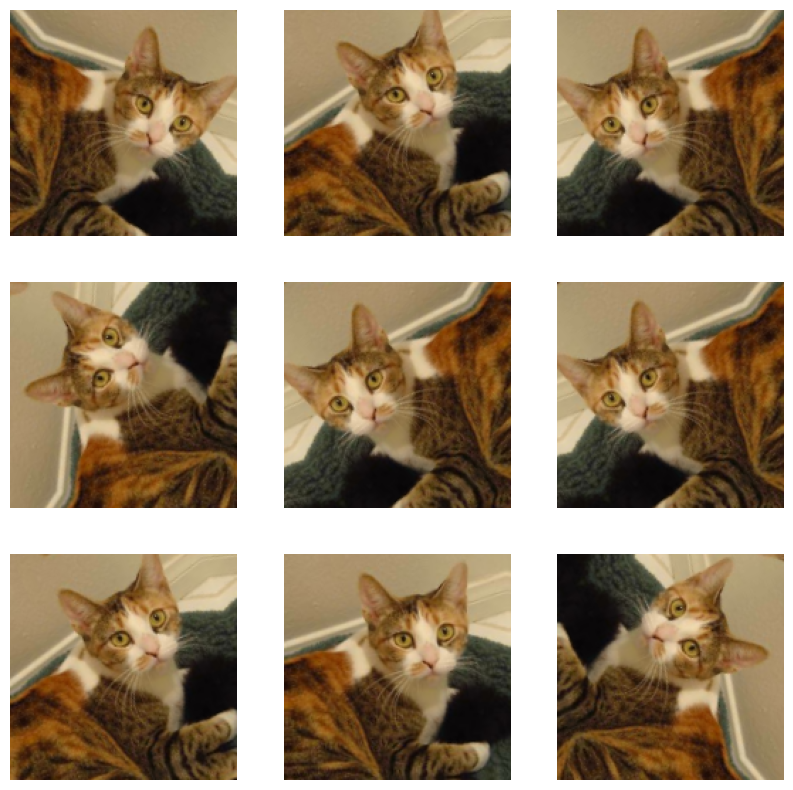

In [ ]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis("off")

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.Rescaling(1.0 / 127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE, include_top=False, weights="imagenet"
)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 18s 614ms/step - loss: 0.7090 - accuracy: 0.5495


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.71
initial accuracy: 0.55


In [ ]:
history = model.fit(
    train_dataset, epochs=initial_epochs, validation_data=validation_dataset
)

Epoch 1/10
63/63 [==============================] - 72s 1s/step - loss: 0.6999 - accuracy: 0.5825 - val_loss: 0.4748 - val_accuracy: 0.7252
Epoch 2/10
63/63 [==============================] - 58s 912ms/step - loss: 0.5257 - accuracy: 0.6885 - val_loss: 0.3560 - val_accuracy: 0.8181
Epoch 3/10
63/63 [==============================] - 88s 1s/step - loss: 0.4199 - accuracy: 0.7820 - val_loss: 0.2773 - val_accuracy: 0.8837
Epoch 4/10
63/63 [==============================] - 62s 992ms/step - loss: 0.3579 - accuracy: 0.8255 - val_loss: 0.2228 - val_accuracy: 0.9121
Epoch 5/10
63/63 [==============================] - 60s 953ms/step - loss: 0.3062 - accuracy: 0.8525 - val_loss: 0.1946 - val_accuracy: 0.9295
Epoch 6/10
63/63 [==============================] - 60s 941ms/step - loss: 0.2729 - accuracy: 0.8835 - val_loss: 0.1741 - val_accuracy: 0.9406
Epoch 7/10
63/63 [==============================] - 55s 870ms/step - loss: 0.2482 - accuracy: 0.8900 - val_loss: 0.1567 - val_accuracy: 0.9455
Epoch

In [ ]:
base_model.trainable = True

In [ ]:
len(model.trainable_variables)

158

In [ ]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=validation_dataset,
)

Epoch 10/20
63/63 [==============================] - 61s 965ms/step - loss: 0.1943 - accuracy: 0.9185 - val_loss: 0.1163 - val_accuracy: 0.9579
Epoch 11/20
63/63 [==============================] - 52s 831ms/step - loss: 0.1925 - accuracy: 0.9195 - val_loss: 0.1142 - val_accuracy: 0.9579
Epoch 12/20
63/63 [==============================] - 59s 945ms/step - loss: 0.1942 - accuracy: 0.9135 - val_loss: 0.1120 - val_accuracy: 0.9579
Epoch 13/20
63/63 [==============================] - 60s 945ms/step - loss: 0.1805 - accuracy: 0.9205 - val_loss: 0.1029 - val_accuracy: 0.9629
Epoch 14/20
63/63 [==============================] - 53s 844ms/step - loss: 0.1837 - accuracy: 0.9185 - val_loss: 0.1012 - val_accuracy: 0.9604
Epoch 15/20
63/63 [==============================] - 60s 948ms/step - loss: 0.1704 - accuracy: 0.9270 - val_loss: 0.0932 - val_accuracy: 0.9678
Epoch 16/20
63/63 [==============================] - 60s 954ms/step - loss: 0.1721 - accuracy: 0.9215 - val_loss: 0.0918 - val_accuracy:

Predictions:
 [1 0 1 0 1 0 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1]
Labels:
 [1 0 1 0 1 0 0 0 1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1]


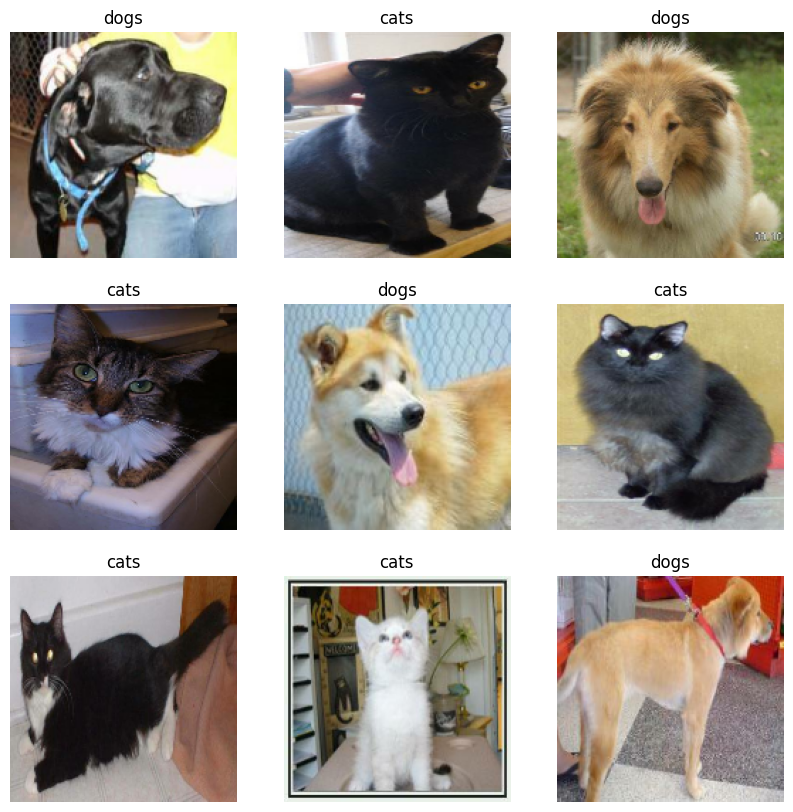

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print("Predictions:\n", predictions.numpy())
print("Labels:\n", label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")

In [ ]:
# Save the model
model_name = "cat-dog-tuned"
model.save(model_name)

2.

In [ ]:
import torch
from torch import nn
import torchvision
import os
from typing import List, Any, Tuple
# from torchinfo import summary
from torchvision.datasets import VisionDataset

In [ ]:
classification_models = torchvision.models.list_models(module=torchvision.models)
print(len(classification_models), "classification models:", classification_models)

80 classification models: ['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'googlenet', 'inception_v3', 'maxvit_t', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext101_64x4d', 'resnext50_32x4d', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflene

In [ ]:
alexnet = torchvision.models.alexnet(weights=None)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
convnext_base = torchvision.models.convnext_base(weights=None)
convnext_base

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [ ]:
dict(alexnet.named_children()).keys()

dict_keys(['features', 'avgpool', 'classifier'])

In [ ]:
layer_count = dict()

for model_name in classification_models:
    m = getattr(torchvision.models, model_name)(weights=None)
    layer_names = dict(m.named_children()).keys()
    for ln in layer_names:
        layer_count[ln] = layer_count.get(ln, 0) + 1
    # end for
# end for

print(layer_count)

/usr/local/lib/python3.10/dist-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


{'features': 39, 'avgpool': 59, 'classifier': 38, 'conv1': 15, 'maxpool1': 2, 'conv2': 1, 'conv3': 1, 'maxpool2': 2, 'inception3a': 1, 'inception3b': 1, 'maxpool3': 1, 'inception4a': 1, 'inception4b': 1, 'inception4c': 1, 'inception4d': 1, 'inception4e': 1, 'maxpool4': 1, 'inception5a': 1, 'inception5b': 1, 'aux1': 1, 'aux2': 1, 'dropout': 2, 'fc': 31, 'Conv2d_1a_3x3': 1, 'Conv2d_2a_3x3': 1, 'Conv2d_2b_3x3': 1, 'Conv2d_3b_1x1': 1, 'Conv2d_4a_3x3': 1, 'Mixed_5b': 1, 'Mixed_5c': 1, 'Mixed_5d': 1, 'Mixed_6a': 1, 'Mixed_6b': 1, 'Mixed_6c': 1, 'Mixed_6d': 1, 'Mixed_6e': 1, 'AuxLogits': 1, 'Mixed_7a': 1, 'Mixed_7b': 1, 'Mixed_7c': 1, 'stem': 16, 'blocks': 1, 'layers': 4, 'trunk_output': 15, 'bn1': 10, 'relu': 10, 'maxpool': 14, 'layer1': 10, 'layer2': 10, 'layer3': 10, 'layer4': 10, 'stage2': 4, 'stage3': 4, 'stage4': 4, 'conv5': 4, 'norm': 6, 'permute': 6, 'flatten': 6, 'head': 6, 'conv_proj': 5, 'encoder': 5, 'heads': 5}


In [ ]:
vgg16 = torchvision.models.vgg16_bn(weights=None)
resnet50 = torchvision.models.resnet50(weights=None)
resnet152 = torchvision.models.resnet152(weights=None)
print("vgg16\n", vgg16.classifier)
print("resnet50\n", resnet50.fc)
print("resnet152\n", resnet152.fc)

vgg16
 Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
resnet50
 Linear(in_features=2048, out_features=1000, bias=True)
resnet152
 Linear(in_features=2048, out_features=1000, bias=True)


3.

In [3]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, ResNet152
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD

# Download and extract the dataset
url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
zip_file = tf.keras.utils.get_file("cats_and_dogs_filtered.zip", url, extract=True)
base_dir = os.path.join(os.path.dirname(zip_file), 'cats_and_dogs_filtered')

# Set up directories for training and validation data
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Set up data generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

# Load pre-trained models
vgg16_base = VGG16(weights='imagenet', include_top=False)
resnet50_base = ResNet50(weights='imagenet', include_top=False)
resnet152_base = ResNet152(weights='imagenet', include_top=False)

# Add custom classifier layers on top of the pre-trained models
def add_custom_layers(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)  # Output layer with binary classification
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Create models with custom layers
vgg16_model = add_custom_layers(vgg16_base)
resnet50_model = add_custom_layers(resnet50_base)
resnet152_model = add_custom_layers(resnet152_base)

# Compile models
# sgd = SGD(lr=0.001, momentum=0.9)
from tensorflow.keras.optimizers import SGD


# sgd = legacy.SGD(lr=0.001, momentum=0.9)
sgd = SGD(learning_rate=0.001, momentum=0.9)


vgg16_model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
resnet50_model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
resnet152_model.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])

trainable_variables = vgg16_model.trainable_variables
print(f"Number of trainable variables: {len(trainable_variables)}")
sgd.build(trainable_variables)
print("Optimizer built successfully")

# Train the models
num_epochs = 5

vgg16_model.fit(train_generator, epochs=num_epochs, validation_data=valid_generator)
resnet50_model.fit(train_generator, epochs=num_epochs, validation_data=valid_generator)
resnet152_model.fit(train_generator, epochs=num_epochs, validation_data=valid_generator)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Number of trainable variables: 30
Optimizer built successfully
Epoch 1/5
63/63 [==============================] - 31s 458ms/step - loss: 0.5533 - accuracy: 0.6945 - val_loss: 0.3530 - val_accuracy: 0.8380
Epoch 2/5
23/63 [=========>....................] - ETA: 16s - loss: 0.2365 - accuracy: 0.9158

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-ae3aff6b1983>", line 74, in <cell line: 74>
    vgg16_model.fit(train_generator, epochs=num_epochs, validation_data=valid_generator)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1813, in fit
    callbacks.on_train_batch_end(end_step, logs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/callbacks.py", line 475, in on_train_batch_end
    self._call_batch_hook(ModeKeys.TRAIN, "end", batch, logs=logs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/callbacks.py", line 322, in _call_batch_hook
    self._call_batch_end_hook(mode, batch, logs)
  File "/usr/local/lib/python3.10/d

TypeError: object of type 'NoneType' has no len()